# 1. Convolutional Variational Autoencoder for CIFAR-10

## 1.1 Imports

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import os
import numpy as np
import time
from torchvision import transforms
from torch.utils.data import DataLoader

## 1.2 Settings

In [2]:
# set device
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# set hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 50
NUM_CLASSES = 10

Device: cpu


In [3]:
# set the environment for deterministic behavior, particularly when using CUDA
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)


# set random seeds to enforce reproducibility
def set_all_seeds(seed):
    os.environ['PL_GLOBAL_SEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_deterministic()
set_all_seeds(RANDOM_SEED)

## 1.3 Dataset

In [4]:
# Load and normalize CIFAR10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=0)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Check the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

print('\nTesting Set:')
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])
tensor([3, 6, 0, 3, 9, 6, 6, 2, 6, 2])

Testing Set:
Image batch dimensions: torch.Size([256, 3, 32, 32])
Image label dimensions: torch.Size([256])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])


## 1.4 Model

In [6]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :32, :32]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, stride=1, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),

            nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),

            nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),

            nn.Conv2d(64, 64, stride=1, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),

            nn.Flatten(),
        )

        self.z_mean = torch.nn.Linear(4096, 100)
        self.z_log_var = torch.nn.Linear(4096, 100)

        self.decoder = nn.Sequential(
            torch.nn.Linear(100, 4096),
            Reshape(-1, 64, 8, 8),
            nn.ConvTranspose2d(64, 64, stride=1, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),

            nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),

            nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.25),

            nn.ConvTranspose2d(32, 3, stride=1, kernel_size=3, padding=1),

            Trim(),

            nn.Sigmoid()
        )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.device)
        z = z_mu + eps * torch.exp(z_log_var / 2.)
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [7]:
set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## 1.5 Training

In [8]:
# define reconstruction loss
def compute_epoch_loss_autoencoder(model, data_loader, loss_fn, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(device)
            logits = model(features)
            loss = loss_fn(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [9]:
# define training process
def train_vae_v1(num_epochs, model, optimizer, device, train_loader, loss_fn=None, logging_interval=10,
                 skip_epoch_stats=False, reconstruction_term_weight=1, save_model=None):
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):
            features = features.to(device)
            encoded, z_mean, z_log_var, decoded = model(features)

            kl_div = -0.5 * torch.sum(1 + z_log_var - z_mean ** 2 - torch.exp(z_log_var), axis=1)
            batchsize = kl_div.size(0)
            kl_div = kl_div.mean()

            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1)
            pixelwise = pixelwise.mean()

            loss = reconstruction_term_weight * pixelwise + kl_div

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f' % (
                epoch + 1, num_epochs, batch_idx, len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()

            with torch.set_grad_enabled(False):
                train_loss = compute_epoch_loss_autoencoder(model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (epoch + 1, num_epochs, train_loss))
                log_dict['train_combined_loss_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time) / 60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time) / 60))

    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict

In [10]:
# training
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, optimizer=optimizer, device=DEVICE,
                        train_loader=train_loader, skip_epoch_stats=True, logging_interval=10)

Epoch: 001/050 | Batch 0000/0196 | Loss: 1751.9302
Epoch: 001/050 | Batch 0010/0196 | Loss: 1184.4460
Epoch: 001/050 | Batch 0020/0196 | Loss: 856.3409
Epoch: 001/050 | Batch 0030/0196 | Loss: 738.3521
Epoch: 001/050 | Batch 0040/0196 | Loss: 669.0982
Epoch: 001/050 | Batch 0050/0196 | Loss: 664.6990
Epoch: 001/050 | Batch 0060/0196 | Loss: 688.3861
Epoch: 001/050 | Batch 0070/0196 | Loss: 620.2156
Epoch: 001/050 | Batch 0080/0196 | Loss: 601.2213
Epoch: 001/050 | Batch 0090/0196 | Loss: 623.9586
Epoch: 001/050 | Batch 0100/0196 | Loss: 617.6603
Epoch: 001/050 | Batch 0110/0196 | Loss: 680.4977
Epoch: 001/050 | Batch 0120/0196 | Loss: 603.4879
Epoch: 001/050 | Batch 0130/0196 | Loss: 605.9116
Epoch: 001/050 | Batch 0140/0196 | Loss: 635.6581
Epoch: 001/050 | Batch 0150/0196 | Loss: 601.5254
Epoch: 001/050 | Batch 0160/0196 | Loss: 598.5131
Epoch: 001/050 | Batch 0170/0196 | Loss: 614.9380
Epoch: 001/050 | Batch 0180/0196 | Loss: 600.4697
Epoch: 001/050 | Batch 0190/0196 | Loss: 607.242

## 1.6 Evaluation

In [11]:
# plot training loss
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):
    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    
    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:]) * 1.5
    ])
    

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations, ) / averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    # Set second x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs + 1))

    newpos = [e * iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())

    plt.tight_layout()

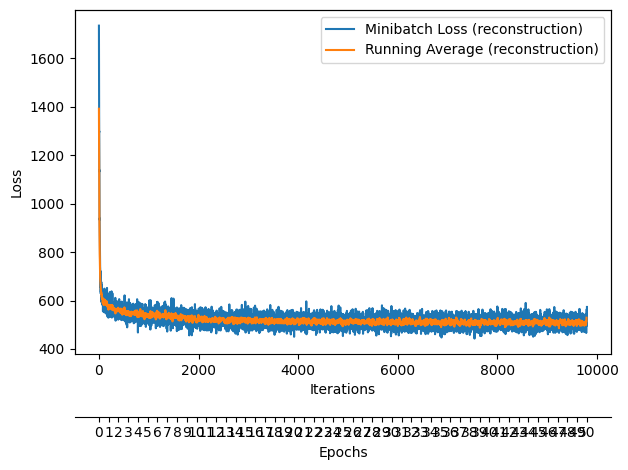

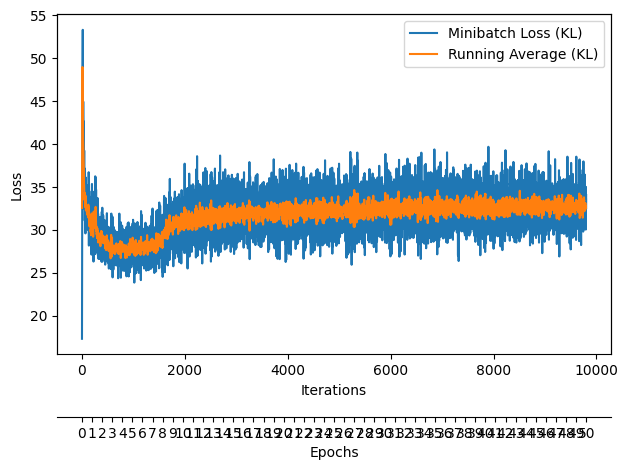

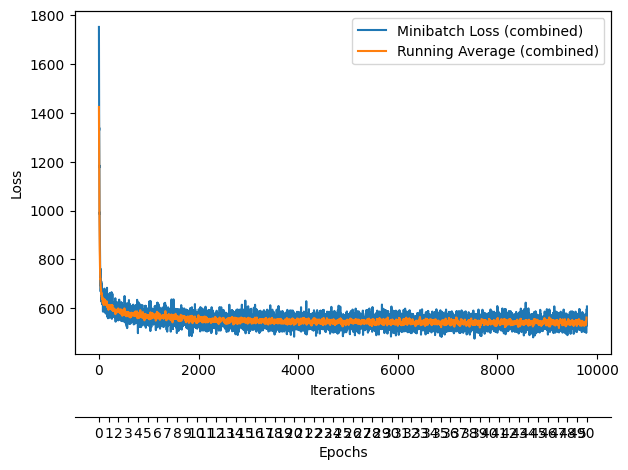

In [12]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

In [13]:
# reverts the normalization transformation
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Parameters:
        ------------
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.

        Returns:
        ------------
        Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


# plot generated images
def plot_generated_images(data_loader, model, device,
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):
    fig, axes = plt.subplots(nrows=2, ncols=n_images,
                             sharex=True, sharey=True, figsize=figsize)

    for batch_idx, (features, _) in enumerate(data_loader):

        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]

        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

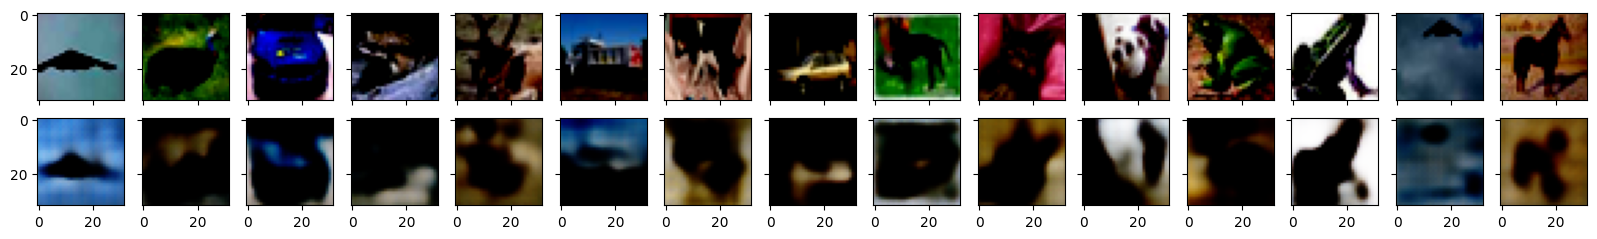

In [14]:
# plot generated images from input images
# unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
plot_generated_images(data_loader=train_loader,
                      model=model,
                      # unnormalizer=unnormalizer,
                      device=DEVICE,
                      modeltype='VAE')

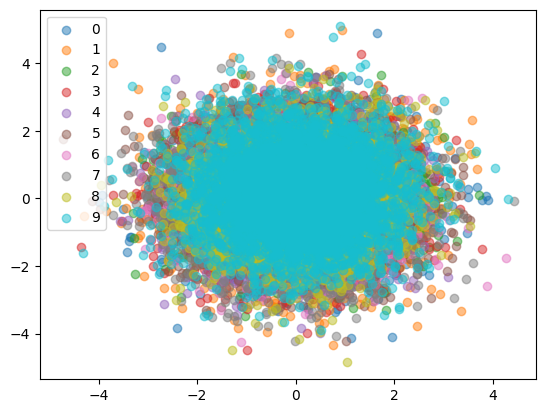

In [15]:
def plot_latent_space_with_labels(num_classes, data_loader, encoding_fn, device):
    d = {i: [] for i in range(num_classes)}

    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)

            embedding = encoding_fn(features)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].to('cpu').numpy())

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()


plot_latent_space_with_labels(
    num_classes=NUM_CLASSES,
    data_loader=train_loader,
    encoding_fn=model.encoding_fn,
    device=DEVICE)

plt.legend()
plt.show()

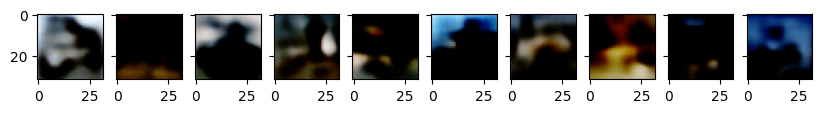

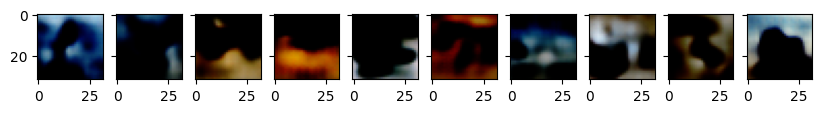

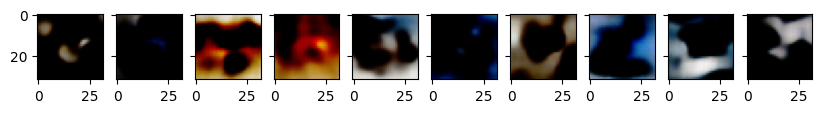

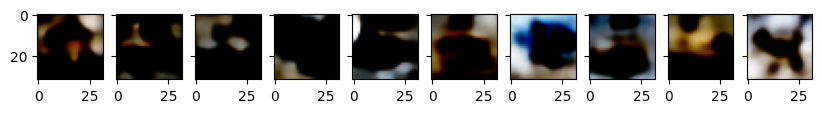

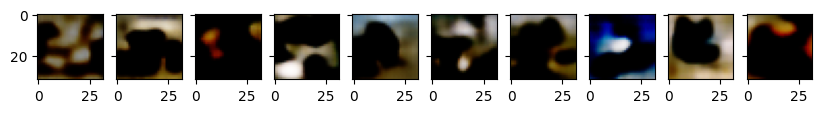

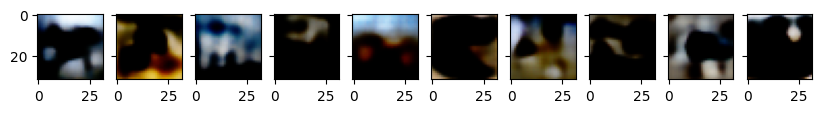

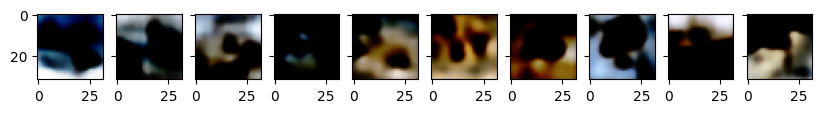

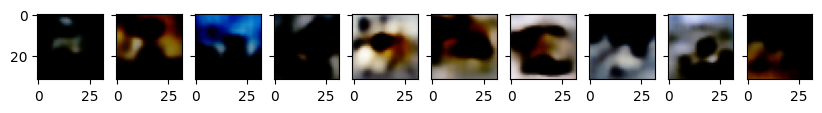

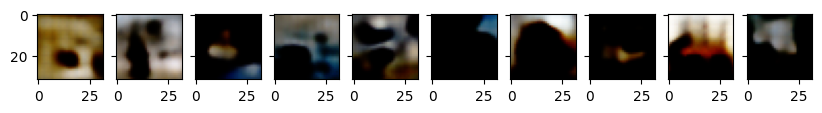

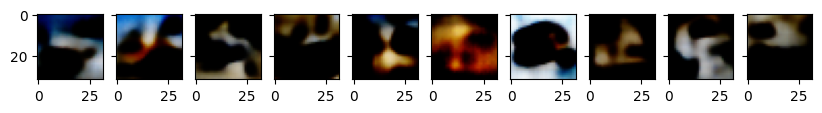

In [17]:
# plot generated images from latent space
def plot_images_sampled_from_vae(model, device, latent_size, unnormalizer=None, num_images=10):
    with torch.no_grad():

        rand_features = torch.randn(num_images, latent_size).to(device)
        new_images = model.decoder(rand_features)
        color_channels = new_images.shape[1]
        image_height = new_images.shape[2]
        image_width = new_images.shape[3]

        image_width = 28

        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 2.5), sharey=True)
        decoded_images = new_images[:num_images]

        for ax, img in zip(axes, decoded_images):
            curr_img = img.detach().to(torch.device('cpu'))
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax.imshow(curr_img)
            else:
                ax.imshow(curr_img.view((image_height, image_width)), cmap='binary')


for i in range(10):
    plot_images_sampled_from_vae(model=model, device=DEVICE, latent_size=100)
    plt.show()